# Modelo K-Nearest Neighbours

### Este modelo fue seleccionado por su carácter no paramétrico y basado en similitud, lo que lo convierte en una alternativa adecuada para trabajar con una base reducida en número de filas pero amplia en cantidad de variables.

### El enfoque principal consiste en explorar patrones locales que permitan discernir entre médicos con y sin riesgo de burnout. Se detallan las fases de preprocesamiento, búsqueda de hiperparámetros, validación cruzada y evaluación de métricas, con el fin de analizar la capacidad predictiva del modelo comparada al resto de los explorados.

In [1]:
# Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar el dataset
file_path = "Proyecto_final.csv"
df = pd.read_csv(file_path, sep=';')

In [3]:
# Calcular LGS_Puntaje
lgs_items = [col for col in df.columns if col.startswith("LGS_") and col != "LGS_Puntaje"]
df["LGS_Puntaje"] = df[lgs_items].sum(axis=1)

# Eliminar columnas relacionadas con el burnout
df = df.drop(columns=["GBC_Puntaje", "AE_MBI", "DSP_MBI", "RP_MBI", "Nivel_AE_MBI", "Nivel_DSP_MBI", "Nivel_RP_MBI"])



In [4]:
# Reemplazar todos los valores de 999 con NaN
df = df.replace([999, '999', 999.0, '999.0'], np.nan)

# Eliminar columnas con más de 20% de valores NaN
threshold = 0.20  # 20%
min_non_na = int((1 - threshold) * len(df))
df = df.dropna(axis=1, thresh=min_non_na)

df.dropna(inplace=True)

print(f"Shape después de la limpieza: {df.shape}")
print(f"Distribución de clases: {df['MBI_Burnout'].value_counts()}")

Shape después de la limpieza: (101, 137)
Distribución de clases: MBI_Burnout
0.0    81
1.0    20
Name: count, dtype: int64


In [5]:
# Seleccionar filas donde la variable objetivo NO es nula
df = df[df['MBI_RiesgoBurnout1'].notna()]

In [6]:
# Definir variable objetivo y features
X = df.drop(columns=["MBI_Burnout", "MBI_RiesgoBurnout1"])  
y = df["MBI_RiesgoBurnout1"]


In [7]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Lleva a demasiado overfitting

#imputer_num = SimpleImputer(strategy="mean")
#X[num_cols] = pd.DataFrame(
#    imputer_num.fit_transform(X[num_cols]), 
#    columns=num_cols, 
#    index=X.index
#)

In [8]:
X = X.select_dtypes(include=[np.number])

In [9]:
# ANALIZAR CORRELACIÓN Y REDUCIR DIMENSIONALIDAD
print("\n=== Análisis de Features ===")

#  Análisis de correlación con target
correlations = []
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    correlations.append((col, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
print("Top 10 features por correlación con objetivo:")
for col, corr in correlations[:20]:
    print(f"  {col}: {corr:.3f}")


=== Análisis de Features ===
Top 10 features por correlación con objetivo:
  MBI_6: 0.619
  MBI_8: 0.584
  MBI_16: 0.575
  MBI_10: 0.519
  MBI_20: 0.512
  MBI_3: 0.469
  MBI_19: 0.458
  MBI_11: 0.434
  MBI_1: 0.432
  MBI_5: 0.420
  MBI_13: 0.396
  PERMA_11_Soledad: 0.391
  PERMA_23_Feliz: 0.384
  PERMA_22_Contento: 0.383
  PERMA_3_Feliz: 0.376
  MBI_18: 0.374
  MBI_22: 0.372
  PERMA_9_Valor_Vida: 0.359
  MBI_17: 0.359
  MBI_12: 0.346


In [10]:
# Random Forest para importancia de features
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)

importances = rf_selector.feature_importances_
feature_importance = list(zip(X.columns, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 15 features por importancia de Random Forest:")
for col, imp in feature_importance[:20]:
    print(f"  {col}: {imp:.4f}")


Top 15 features por importancia de Random Forest:
  MBI_6: 0.0684
  MBI_8: 0.0664
  MBI_16: 0.0569
  MBI_20: 0.0548
  MBI_10: 0.0473
  MBI_17: 0.0368
  MBI_19: 0.0315
  MBI_11: 0.0299
  MBI_5: 0.0278
  PERMA_11_Soledad: 0.0270
  MBI_3: 0.0252
  MBI_1: 0.0229
  MBI_18: 0.0228
  AñosPractica: 0.0205
  PERMA_9_Valor_Vida: 0.0200
  MBI_13: 0.0159
  Especialidad: 0.0159
  Edad: 0.0144
  MBI_22: 0.0136
  MBI_21: 0.0135


In [11]:
# Seleccionar las mejores features (máximo 20 para evitar overfitting)
top_features = [col for col, imp in feature_importance[:20]]
X_reduced = X[top_features]
print(f"\nShape con features reducidas: {X_reduced.shape}")


Shape con features reducidas: (101, 20)


In [12]:
# Dividir el train/test con el dataset reducido
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.4, stratify=y, random_state=42
)


In [13]:
# PIPELINE CON VALIDACIÓN  ROBUSTA
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Usar median para outliers
    ("scaler", RobustScaler()),  # Más robusto que StandardScaler
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13],  # Valores más razonables
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"],
    "knn__p": [1, 2]  # Para minkowski
}

# Validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Más folds

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

In [14]:
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor puntaje CV:", grid.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Mejores parámetros: {'knn__metric': 'euclidean', 'knn__n_neighbors': 13, 'knn__p': 1, 'knn__weights': 'uniform'}
Mejor puntaje CV: 0.9375


In [15]:
# EVALUACIÓN MÁS COMPLETA
print("\n=== Evaluación del modelo ===")

# Puntaje de evaluación cruzada en trainings
cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           scoring='f1_weighted')
print(f"Puntaje de evaluación cruzada: {cv_scores}")
print(f"CV Media: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



=== Evaluación del modelo ===
Puntaje de evaluación cruzada: [0.92016807 0.92016807 0.76666667 0.91052632 0.91052632]
CV Media: 0.886 (+/- 0.119)


In [16]:
# Evaluar en test
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

if len(np.unique(y)) == 2:
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba[:, 1]):.3f}")


Test Accuracy: 0.927
Precision: 0.943
Recall: 0.927
F1-score: 0.929
ROC-AUC: 0.959



Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        11
         1.0       1.00      0.90      0.95        30

    accuracy                           0.93        41
   macro avg       0.89      0.95      0.91        41
weighted avg       0.94      0.93      0.93        41



Text(0.5, 1.0, 'Matriz de Confusión')

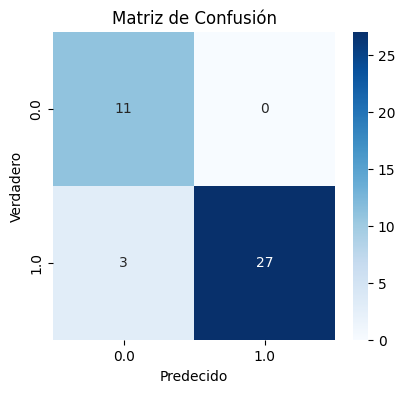

In [17]:
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predecido")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")

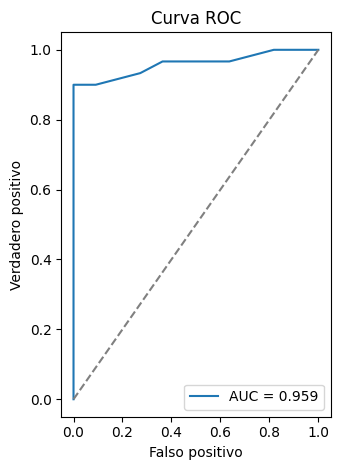

In [18]:
# ROC Curva
if len(np.unique(y)) == 2:
    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Falso positivo")
    plt.ylabel("Verdadero positivo")
    plt.title("Curva ROC")
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# ANÁLISIS DE FEATURES FINALES
print("\n=== FINAL FEATURE ANALYSIS ===")
best_knn = grid.best_estimator_

# Importancia según permutacion
perm_importance = permutation_importance(best_knn, X_test, y_test, 
                                        n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({
    'feature': X_reduced.columns,
    'importancia': perm_importance.importances_mean
}).sort_values('importancia', ascending=False)

print("Top features por importancia según permutación:")
print(perm_importance_df.head(10))


=== FINAL FEATURE ANALYSIS ===
Top features por importancia según permutación:
   feature  importancia
3   MBI_20     0.029268
18  MBI_22     0.029268
1    MBI_8     0.026829
7   MBI_11     0.024390
0    MBI_6     0.021951
5   MBI_17     0.019512
11   MBI_1     0.007317
15  MBI_13     0.004878
10   MBI_3     0.004878
4   MBI_10     0.002439


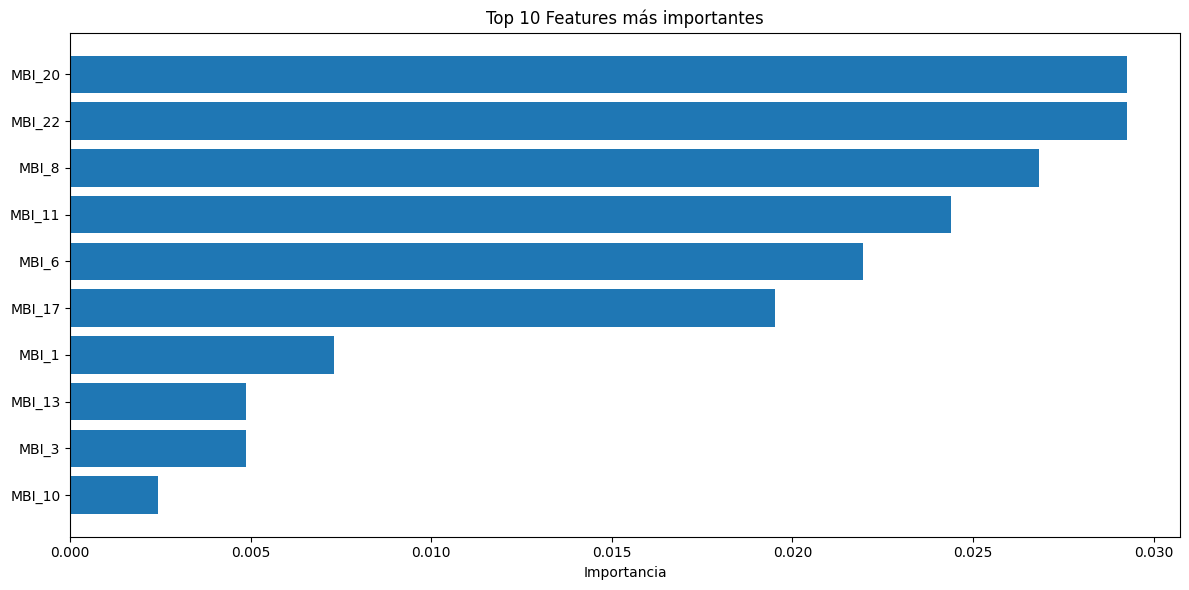

In [20]:
# VISUALIZACIÓN DE FEATURES IMPORTANTES
plt.figure(figsize=(12, 6))
top_10_features = perm_importance_df.head(10)
plt.barh(top_10_features['feature'], top_10_features['importancia'])
plt.xlabel('Importancia')
plt.title('Top 10 Features más importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
# VERIFICACIÓN FINAL DE OVERFITTING
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

print(f"\n=== OVERFITTING CHECK ===")
print(f"Puntaje en training: {train_score:.3f}")
print(f"Puntaje en test: {test_score:.3f}")
print(f"Diferencia: {abs(train_score - test_score):.3f}")



=== OVERFITTING CHECK ===
Puntaje en training: 0.919
Puntaje en test: 0.929
Diferencia: 0.010
